# OCTDL (Optical Coherence Tomography Dataset for Image-Based Deep Learning Method)
### Download dataset: https://www.kaggle.com/datasets/shakilrana/octdl-retinal-oct-images-dataset
#### For more information and details about the dataset see: https://arxiv.org/abs/2312.08255

I downloaded a dataset that contains folders of retinal OCT images, each corresponding to a different eye disease such as AMD, DME, ERM, RAO, RVO, and others. Alongside the images, there is a CSV file that provides metadata for each scan, including the image filename, disease type, subcategory, condition, patient ID, eye (OD/OS), sex, year of birth, and image dimensions (width and height). The OCT images serve as the input data for deep learning model training, while the CSV file provides the ground truth labels and additional information necessary to organize, preprocess, and evaluate the dataset. The primary goal is to develop and assess a machine learning model capable of automatically classifying OCT images based on retinal disease type.

In [3]:
# %pip install torch torchvision torchaudio

In [4]:
# !pip install scipy

In [1]:
# Step 1: import essential libraries

import os # for working with file paths
import pandas as pd # for reading and handling the CSV file
import matplotlib.pyplot as plt # for showing sample images
from PIL import Image # for opening image files
import random # for random shuffling or sampling
from sklearn.model_selection import GroupShuffleSplit # for splitting data while keeping grouped samples together
import numpy as np # for numerical operations and arrays
import torch # main PyTorch library for tensors and deep learning
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler # for creating datasets, batching, and handling imbalanced data
import torchvision.transforms as T # for applying image transformations (resize, normalize, augment, etc.)
from collections import Counter # for counting label frequencies (useful for class balance)
import torch.nn as nn # for defining neural network layers and models
import torchvision.models as models # for using pretrained CNN models (like ResNet, VGG, etc.)
import time # for tracking training duration or timing code
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score # for evaluating model performance
from datetime import datetime # for timestamps when saving checkpoints or logs
import torch.nn.functional as F # for additional neural network operations like activations and loss functions


In [2]:
# Step 2: set paths and load the CSV

# define the main dataset folder and the CSV file location
ROOT = r"C:\Users\annaj\Desktop\Python\Project OCTDL\OCTDL Optical Coherence Tomography Dataset for Image-Based Deep Learning Methods\OCTDL\OCTDL"
CSV_PATH = r"C:\Users\annaj\Desktop\Python\Project OCTDL\OCTDL Optical Coherence Tomography Dataset for Image-Based Deep Learning Methods\OCTDL_labels.csv"

# read the CSV file into a DataFrame
df = pd.read_csv(CSV_PATH)

# clean up column names (convert to lowercase and remove extra spaces)
df.columns = [c.strip().lower() for c in df.columns]

# print number of rows and list of column names
print("Rows:", len(df))
print("Columns:", list(df.columns))
display(df.head(8)) # show first 8 rows for quick check

# check if 'disease' column exists and show class distribution
if "disease" in df.columns:
    print("\nCounts per class:")
    display(df["disease"].value_counts().to_frame("count")) # show count per disease class
else:
    print("\nCould not find 'disease' column — check CSV headers printed above.") # warning if column missing

Rows: 2064
Columns: ['file_name', 'disease', 'subcategory', 'condition', 'patient_id', 'eye', 'sex', 'year', 'image_width', 'image_hight']


,file_name,disease,subcategory,condition,patient_id,eye,sex,year,image_width,image_hight
0,amd_1047099_1,AMD,intermediate,MNV_suspected,1047099,0,0,0,1101,410
1,amd_1047099_2,AMD,intermediate,MNV_suspected,1047099,0,0,0,731,265
2,amd_1047099_3,AMD,intermediate,MNV_suspected,1047099,0,0,0,1100,410
3,amd_1047099_4,AMD,intermediate,MNV_suspected,1047099,0,0,0,882,321
4,amd_1084498_1,AMD,late,MNV,1084498,0,0,0,882,321
5,amd_1084498_2,AMD,late,MNV,1084498,0,0,0,743,311
6,amd_1084498_3,AMD,late,MNV,1084498,0,0,0,881,313
7,amd_1096590_1,AMD,late,MNV,1096590,0,0,0,741,312



Counts per class:


,count
disease,
AMD,1231
NO,332
ERM,155
DME,147
RVO,101
VID,76
RAO,22


Before initiating the deep learning model training, it is essential to verify the integrity and completeness of the dataset. Specifically, each image referenced in the accompanying CSV file must exist within its designated directory. Datasets occasionally contain missing or incorrectly placed files, which can lead to runtime errors during data loading and preprocessing. To ensure data consistency, a validation loop is implemented that iterates through each record in the CSV file, constructs the full image path (e.g., AMD/amd_1047099_1.jpg), and confirms the existence of the corresponding file in the appropriate folder. Successful verification of all entries indicates that the dataset is complete and ready for subsequent model training.

In [6]:
# Step 3: verify that each CSV entry corresponds to a real image file

missing = [] # list to store paths of missing images

# loop through each file name and label in the CSV
for fname, label in zip(df["file_name"], df["disease"]):
    img_path = os.path.join(ROOT, label, f"{fname}.jpg") # build the full path to the image
    if not os.path.exists(img_path): # check if the image file actually exists
        missing.append(img_path) # add missing file path to the list

# print how many files are missing
print(f"Total missing: {len(missing)}")

# show a few examples if any files are missing
if len(missing) > 0:
    print("Example missing paths:")
    print(missing[:10])
else:
    print("All images are present and correctly linked to CSV entries!") # confirmation message


Total missing: 0
All images are present and correctly linked to CSV entries!


Before commencing model training, it is beneficial to conduct an initial visual inspection of the dataset. Displaying representative sample images from each disease category allows for a preliminary understanding of the dataset’s visual characteristics and quality. This step helps verify that the images are being loaded correctly, while also revealing potential variations in image resolution, brightness, or texture across different classes. By selecting one or two random samples from each disease group (e.g., AMD, DME, ERM, etc.) and presenting them in a grid format, we can qualitatively assess the visual diversity of the data and gain an intuitive overview of the input that the model will subsequently learn from.

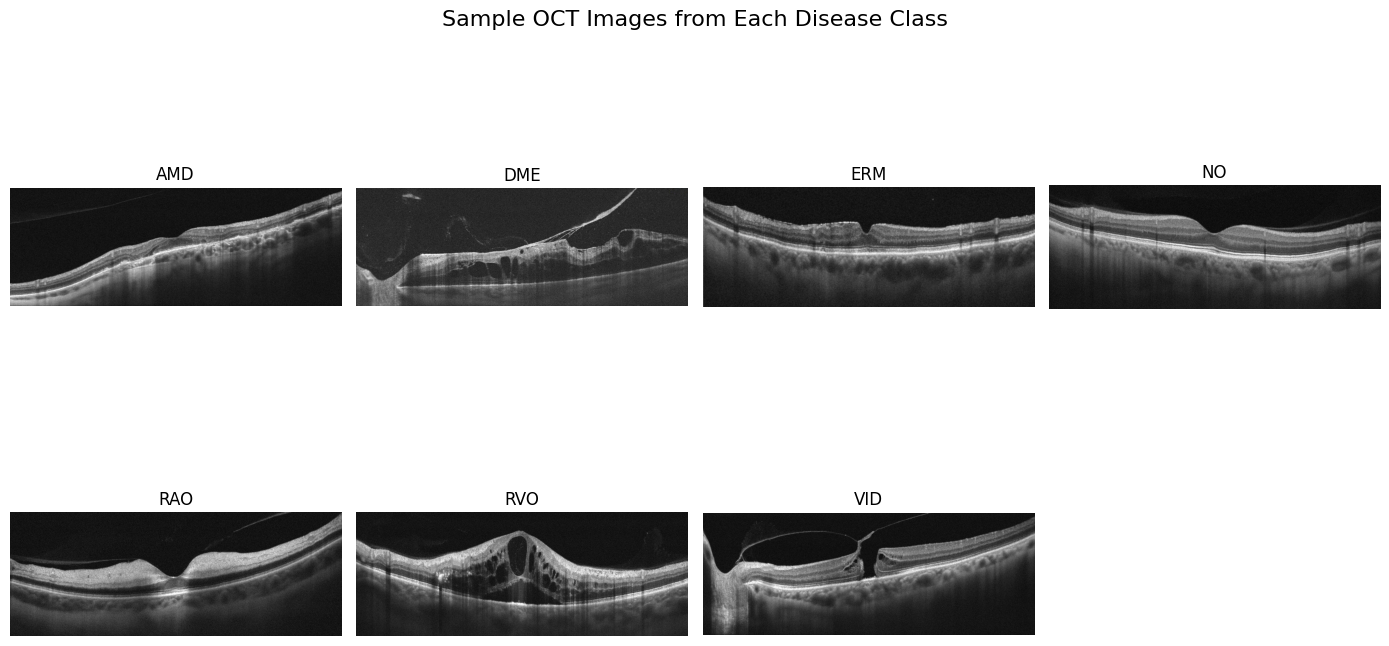

In [9]:
# Step 4: visualize sample OCT images from each disease class

classes = df["disease"].unique() # get the list of all unique disease categories
plt.figure(figsize=(14, 8)) # set figure size for better display

# loop through each disease class (show up to 7)
for i, cls in enumerate(classes[:7]):
    sample = df[df["disease"] == cls].sample(1).iloc[0] # randomly select one image from this class
    img_path = os.path.join(ROOT, cls, f"{sample['file_name']}.jpg") # build the image path
    img = Image.open(img_path) # open the image file
    
    plt.subplot(2, 4, i+1) # define subplot position in a 2x4 grid
    plt.imshow(img, cmap='gray') # show image in grayscale
    plt.title(cls) # set title as the disease name
    plt.axis('off') # hide axis lines and ticks

plt.suptitle("Sample OCT Images from Each Disease Class", fontsize=16) # main title
plt.tight_layout() # adjust layout to avoid overlaps
plt.show() # display the grid of images

To ensure a fair and unbiased evaluation of the model, it is crucial to prevent data leakage—specifically, avoiding situations where images from the same patient appear in both the training and testing sets. Such overlap could artificially inflate model performance, as the model might “memorize” features from similar slices rather than learning generalizable patterns. To address this, the dataset is partitioned into three subsets—training (70%), validation (15%), and testing (15%)-based on unique patient identifiers. This grouping guarantees that all images from a single patient remain within the same subset. The splitting process is performed in two stages: first dividing the data into training and a temporary subset, and then splitting the temporary subset into validation and testing sets. The resulting subsets are saved as separate CSV files for reproducibility, and summary statistics are displayed to verify that the class distributions remain balanced across splits.

In [12]:
# Helper: one-shot group split
def group_split(df, test_size, random_state):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state) # group-aware split
    idx_train, idx_test = next(gss.split(df, groups=df["patient_id"])) # keep all images from a patient in one split
    return df.iloc[idx_train].copy(), df.iloc[idx_test].copy()

# 70/30 first, then 15/15 from the 30
train_df, temp_df = group_split(df, test_size=0.30, random_state=42) # create train vs temp (grouped by patient_id)
val_df,   test_df = group_split(temp_df, test_size=0.50, random_state=43) # split temp into val and test

# Quick summaries
def summarize(name, d):
    print(f"{name}: {len(d):4d} images | {d['patient_id'].nunique():3d} patients") # count images and unique patients
    print(d['disease'].value_counts().to_frame('count').T) # class distribution for this split

summarize("TRAIN", train_df)
summarize("VAL  ", val_df)
summarize("TEST ", test_df)

# Save splits for reuse
train_df.to_csv("octdl_train.csv", index=False) # persist train split
val_df.to_csv("octdl_val.csv", index=False)     # persist val split
test_df.to_csv("octdl_test.csv", index=False)   # persist test split

print("\nSaved: octdl_train.csv, octdl_val.csv, octdl_test.csv")


TRAIN: 1456 images | 574 patients
disease  AMD   NO  DME  ERM  RVO  VID  RAO
count    869  244  109   97   73   49   15
VAL  :  309 images | 123 patients
disease  AMD  NO  ERM  DME  VID  RVO  RAO
count    161  65   26   24   14   13    6
TEST :  299 images | 123 patients
disease  AMD  ERM  NO  RVO  DME  VID  RAO
count    201   32  23   15   14   13    1

Saved: octdl_train.csv, octdl_val.csv, octdl_test.csv


To prepare the data for training within the PyTorch framework, the CSV-based splits must be converted into dataset and dataloader objects. The dataset class is responsible for fetching individual samples—each consisting of an image and its corresponding label—while the dataloader efficiently groups multiple samples into batches and applies lightweight augmentations such as resizing, cropping, and horizontal flipping. This batching process ensures efficient GPU utilization and helps improve model generalization. Additionally, a class-to-index mapping is constructed to translate categorical disease names into numerical labels suitable for training. To mitigate the effects of class imbalance, an optional weighted sampling strategy is introduced, allowing underrepresented classes to be sampled more frequently during training and thereby promoting more balanced model learning.

In [15]:
# Step 6: build PyTorch datasets & dataloaders
# Load saved splits datasets
train_df = pd.read_csv("octdl_train.csv") # training split
val_df = pd.read_csv("octdl_val.csv") # validation split
test_df = pd.read_csv("octdl_test.csv") # test split

# Create full file paths for convenience
def add_path_column(d):
    return d.assign(path=d.apply(lambda r: os.path.join(ROOT, r["disease"], f"{r['file_name']}.jpg"), axis=1)) # add full file path

train_df = add_path_column(train_df) # add path to train
val_df = add_path_column(val_df) # add path to val
test_df = add_path_column(test_df) # add path to test

# Consistent class mapping (string to int)
classes = sorted(train_df["disease"].unique()) # fixed order of classes
class_to_idx = {c:i for i,c in enumerate(classes)} # map class name -> index
idx_to_class = {i:c for c,i in class_to_idx.items()} # map index -> class name
print("Classes:", class_to_idx) # show mapping

# Transforms (simple, OCT-safe)
train_tf = T.Compose([
    T.Resize((256, 256)), # standardize size
    T.RandomResizedCrop(224, scale=(0.9, 1.0)), # light augmentation
    T.RandomHorizontalFlip(p=0.5), # flip augmentation
    T.ToTensor(), # to torch tensor [0,1]
])
eval_tf = T.Compose([
    T.Resize((224, 224)), # deterministic resize
    T.ToTensor(), # to tensor
])

class OCTDLDataset(Dataset):
    def __init__(self, df, transform, class_to_idx):
        self.df = df.reset_index(drop=True) # clean index
        self.transform = transform # store transforms
        self.class_to_idx = class_to_idx # store mapping
        self.targets = self.df["disease"].map(self.class_to_idx).astype(int).tolist() # cache labels

    def __len__(self):
        return len(self.df) # number of samples

    def __getitem__(self, i):
        row = self.df.iloc[i] # select row
        img = Image.open(row["path"]).convert("L") # open as grayscale
        img = self.transform(img) # apply transforms
        if img.ndimension() == 3 and img.size(0) == 1: # if 1 channel
            img = img.repeat(3, 1, 1) # repeat to 3 channels (for CNNs)
        label = self.class_to_idx[row["disease"]] # integer label
        return img, label # return sample

# Datasets
train_ds = OCTDLDataset(train_df, transform=train_tf, class_to_idx=class_to_idx) # training dataset
val_ds = OCTDLDataset(val_df, transform=eval_tf, class_to_idx=class_to_idx) # validation dataset
test_ds = OCTDLDataset(test_df, transform=eval_tf, class_to_idx=class_to_idx) # test dataset

# Optional: weighted sampling to counter class imbalance
counts = Counter(train_df["disease"]) # class counts
class_weights = torch.tensor([1.0 / (counts[c] ** 0.5) for c in classes], dtype=torch.float) # inverse sqrt frequency
sample_weights = [class_weights[t] for t in train_ds.targets] # per-sample weights
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True) # sampler object

# Dataloaders
# if using sampler: set shuffle=False and pass sampler=sampler
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0, pin_memory=False) # training loader
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=False) # validation loader
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=False) # test loader

len(train_ds), len(val_ds), len(test_ds), classes # quick sanity check


Classes: {'AMD': 0, 'DME': 1, 'ERM': 2, 'NO': 3, 'RAO': 4, 'RVO': 5, 'VID': 6}


(1456, 309, 299, ['AMD', 'DME', 'ERM', 'NO', 'RAO', 'RVO', 'VID'])

For this experiment, a ResNet-18 architecture is employed as the image classification backbone. Because the OCT images are grayscale, their single-channel input is duplicated across three channels to match the RGB input format expected by the network. A pretrained ResNet-18 model is loaded when available, leveraging transfer learning to accelerate convergence; if pretrained weights cannot be downloaded, the model is initialized randomly. The final fully connected layer is replaced to produce outputs corresponding to seven disease classes. To optimize learning, a weighted cross-entropy loss function is defined to mitigate the influence of class imbalance, and the AdamW optimizer is selected for its stability and adaptive learning rate behavior. Finally, a single forward pass using one training batch is executed to verify the dimensional consistency of tensors and to compute an initial test loss prior to full training.

In [18]:
# Step 7: define model, loss, optimizer; run a sanity forward pass

device = "cuda" if torch.cuda.is_available() else "cpu" # use GPU if available
num_classes = len(classes) # number of disease categories

# Build ResNet18 (prefer pretrained; fall back if not available)
try:
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # load pretrained weights
    print("Loaded ResNet18 with pretrained weights.")
except Exception as e:
    print("Pretrained weights unavailable, using random init:", e) # if download fails
    model = models.resnet18(weights=None) # random initialization

# Replace the final classification layer for our 7 classes
model.fc = nn.Linear(model.fc.in_features, num_classes) # modify last layer
model = model.to(device) # move model to GPU or CPU

# Loss with class weights (handles imbalance), optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device)) # weighted cross-entropy loss
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4) # AdamW optimizer

# => Sanity check: one batch through the network
xb, yb = next(iter(train_dl)) # get one batch from dataloader
xb, yb = xb.to(device), yb.to(device) # move batch to device

with torch.no_grad(): # disable gradient calculation
    logits = model(xb) # forward pass
    test_loss = criterion(logits, yb) # compute loss for this batch

print(f"Device: {device}") # print current device
print(f"Input batch shape: {xb.shape}") # [B, 3, 224, 224]
print(f"Logits shape: {logits.shape}") # [B, 7]
print(f"Sample loss: {test_loss.item():.4f}") # display test loss value


Loaded ResNet18 with pretrained weights.
Device: cpu
Input batch shape: torch.Size([32, 3, 224, 224])
Logits shape: torch.Size([32, 7])
Sample loss: 2.2625


In the next step, the model is trained iteratively over multiple epochs. During each training iteration, the network processes a batch of images to generate label predictions, after which the cross-entropy loss is computed to quantify the discrepancy between predicted and true labels. The AdamW optimizer is then applied to update the model parameters based on the computed gradients. Following each epoch, the model’s performance is evaluated on the validation set to assess its generalization capability. A checkpointing mechanism is employed to save the model state whenever an improvement in validation accuracy is observed, thereby ensuring retention of the best-performing version. This procedure establishes a stable and reproducible baseline for subsequent experimentation and fine-tuning.

In [21]:
# Step 8: train for a few epochs, validate each epoch, save best model
best_val_acc = 0.0 # track best validation accuracy
best_path = "resnet18_octdl_best.pth" # path to save best model

# simple one-epoch runner
def run_epoch(dataloader, train=True):
    if train:
        model.train() # enable training mode (gradients on)
    else:
        model.eval() # evaluation mode (no dropout, no grad)
    total, correct, loss_sum = 0, 0, 0.0 # reset counters

    for xb, yb in dataloader: # loop through all batches
        xb, yb = xb.to(device), yb.to(device) # move data to device

        if train:
            optimizer.zero_grad() # clear old gradients
            out = model(xb) # forward pass
            loss = criterion(out, yb) # compute loss
            loss.backward() # backpropagation
            optimizer.step() # update weights
        else:
            with torch.no_grad(): # no gradients for validation
                out = model(xb)
                loss = criterion(out, yb)

        loss_sum += loss.item() * xb.size(0) # accumulate total loss
        correct += (out.argmax(1) == yb).sum().item() # count correct preds
        total += xb.size(0) # total number of samples

    return loss_sum / total, correct / total # average loss and accuracy

epochs = 5 # number of epochs to train

for epoch in range(1, epochs + 1):
    t0 = time.time() # start timer
    tr_loss, tr_acc = run_epoch(train_dl, train=True) # train for one epoch
    va_loss, va_acc = run_epoch(val_dl, train=False) # evaluate on validation set

    # save checkpoint if validation accuracy improves
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), best_path) # save model weights

    dt = time.time() - t0 # epoch duration
    print(f"epoch {epoch:02d} | train acc {tr_acc:.3f} loss {tr_loss:.3f} "
          f"| val acc {va_acc:.3f} loss {va_loss:.3f} | {dt:.1f}s") # print summary

print(f"\nTraining complete. Best val acc: {best_val_acc:.3f} (saved: {best_path})") # final message

epoch 01 | train acc 0.773 loss 0.816 | val acc 0.786 loss 0.647 | 197.6s
epoch 02 | train acc 0.916 loss 0.352 | val acc 0.790 loss 0.675 | 192.1s
epoch 03 | train acc 0.932 loss 0.242 | val acc 0.867 loss 0.420 | 178.3s
epoch 04 | train acc 0.946 loss 0.221 | val acc 0.858 loss 0.466 | 170.3s
epoch 05 | train acc 0.958 loss 0.129 | val acc 0.858 loss 0.532 | 174.3s

Training complete. Best val acc: 0.867 (saved: resnet18_octdl_best.pth)


Next, the best-performing model checkpoint saved during training is reloaded and evaluated on the held-out test set, which the model has not previously encountered. This final evaluation stage provides an unbiased assessment of the model’s generalization capability. Two primary analyses are conducted: (a) a comprehensive classification report summarizing precision, recall, and F1-scores for each disease category along with macro-averaged metrics, and (b) a confusion matrix illustrating the distribution of correct and misclassified predictions across classes. Together, these evaluations yield the key performance indicators for the study and offer valuable insights into the model’s strengths and areas of systematic misclassification.

C:\Users\annaj\anaconda3\envs\ds660\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\annaj\anaconda3\envs\ds660\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\annaj\anaconda3\envs\ds660\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         AMD      0.989     0.861     0.920       201
         DME      0.524     0.786     0.629        14
         ERM      0.821     0.719     0.767        32
          NO      0.538     0.913     0.677        23
         RAO      0.000     0.000     0.000         1
         RVO      0.480     0.800     0.600        15
         VID      0.909     0.769     0.833        13

    accuracy                          0.836       299
   macro avg      0.609     0.692     0.632       299
weighted avg      0.882     0.836     0.849       299



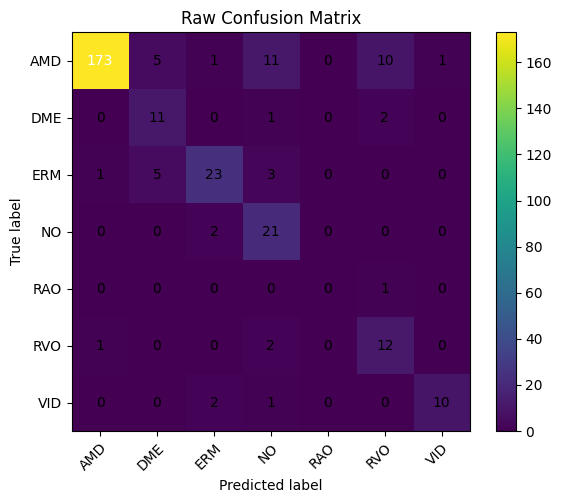

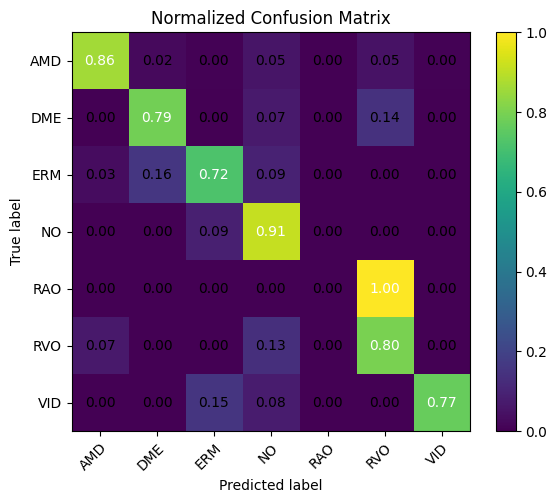


Test accuracy: 0.836 | Macro-F1: 0.632


In [25]:
# Step 9: test-time evaluation (classification report + confusion matrix)

# CPU-friendly test loader (same settings used during training and validation)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)

# Load best checkpoint and set model to evaluation mode
model.load_state_dict(torch.load("resnet18_octdl_best.pth", map_location=device)) # load saved best model
model.eval() # disable dropout and gradient updates

# Collect predictions
y_true, y_pred = [], [] # store true and predicted labels
with torch.no_grad(): # disable gradient calculation
    for xb, yb in test_dl: # loop through test batches
        xb, yb = xb.to(device), yb.to(device) # move to device
        logits = model(xb) # forward pass
        preds = logits.argmax(1) # predicted class index
        y_true.extend(yb.cpu().numpy()) # append true labels
        y_pred.extend(preds.cpu().numpy()) # append predicted labels

y_true = np.array(y_true) # convert to numpy array
y_pred = np.array(y_pred)

# 1) Classification report (precision, recall, F1)
print(classification_report(y_true, y_pred, target_names=classes, digits=3))

# 2) Confusion matrix (raw + normalized)
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes)))) # compute confusion matrix

def plot_cm(cm, classes, normalize=False):
    cm_show = cm.astype("float") # convert to float
    if normalize:
        cm_show = cm_show / cm_show.sum(axis=1, keepdims=True).clip(min=1) # normalize rows

    fig, ax = plt.subplots(figsize=(6,5)) # create figure
    im = ax.imshow(cm_show, interpolation="nearest") # display matrix
    ax.figure.colorbar(im, ax=ax) # add colorbar
    ax.set(
        xticks=np.arange(len(classes)),
        yticks=np.arange(len(classes)),
        xticklabels=classes, yticklabels=classes,
        ylabel="True label", xlabel="Predicted label",
        title=("Normalized" if normalize else "Raw") + " Confusion Matrix",
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") # rotate x labels

    # annotate each cell
    thresh = cm_show.max() / 2.0
    for i in range(cm_show.shape[0]):
        for j in range(cm_show.shape[1]):
            txt = f"{cm_show[i,j]:.2f}" if normalize else f"{int(cm_show[i,j])}" # format numbers
            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm_show[i,j] > thresh else "black") # adjust text color
    fig.tight_layout()
    plt.show()

plot_cm(cm, classes, normalize=False) # raw confusion matrix
plot_cm(cm, classes, normalize=True) # normalized confusion matrix

# Headline metrics
acc = accuracy_score(y_true, y_pred) # overall accuracy
macro_f1 = f1_score(y_true, y_pred, average="macro") # macro-averaged F1
print(f"\nTest accuracy: {acc:.3f} | Macro-F1: {macro_f1:.3f}") # print final results


While quantitative performance metrics provide objective measures of accuracy, clinicians often seek interpretability to understand why a model makes a particular decision. To address this, Gradient-weighted Class Activation Mapping (Grad-CAM) is employed to visualize the regions within an image that most strongly influence the model’s prediction. Specifically, the final convolutional block (layer4) of the ResNet-18 network is used to extract activation maps and their corresponding gradients. By performing a single forward and backward pass for each test image, a class-discriminative heatmap is generated and overlaid on the original OCT image. For interpretability, one representative test image from each disease class is visualized along with its predicted label, providing an intuitive explanation of the model’s decision process and enhancing its clinical transparency.

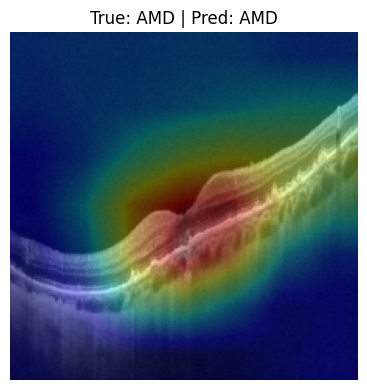

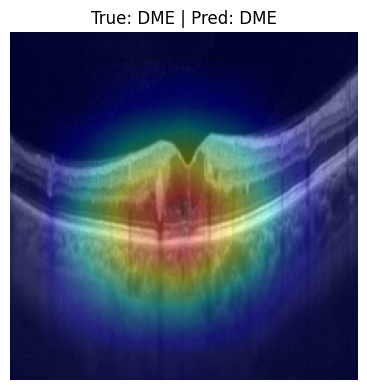

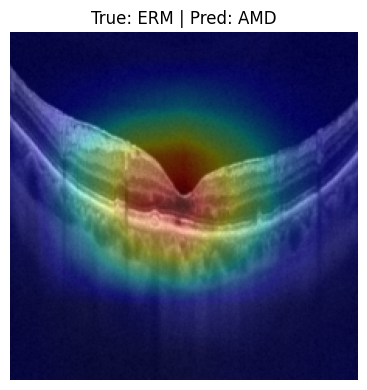

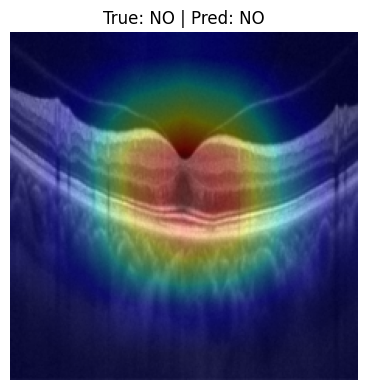

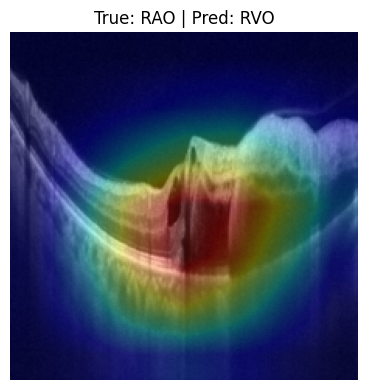

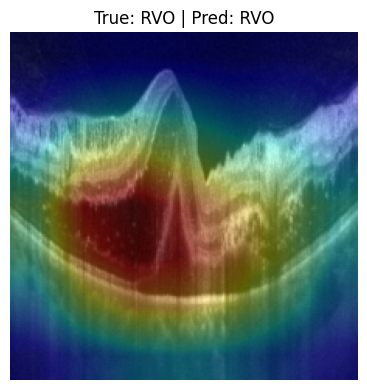

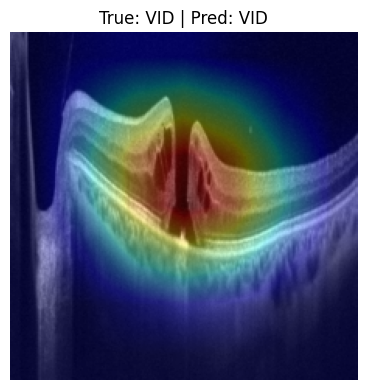

In [28]:
# Step 10: Higher-res Grad-CAM (upsampled to 224×224) with proper overlay

model.eval() # set model to evaluation mode

def gradcam_upsampled(model, x, class_idx=None, target_layer=None):
    if target_layer is None:
        target_layer = model.layer4 # use the last conv block

    activations, gradients = [], [] # buffers to store forward activations and backward gradients

    def fwd_hook(m, i, o): activations.append(o.detach()) # save activations
    def bwd_hook(m, gi, go): gradients.append(go[0].detach()) # save gradients wrt activations

    h1 = target_layer.register_forward_hook(fwd_hook) # attach forward hook
    h2 = target_layer.register_full_backward_hook(bwd_hook) # attach backward hook

    scores = model(x) # forward pass to get class scores
    if class_idx is None:
        class_idx = scores.argmax(1).item() # default to top-1 class

    one_hot = torch.zeros_like(scores) # one-hot for targeted backprop
    one_hot[0, class_idx] = 1
    model.zero_grad() # clear old grads
    scores.backward(gradient=one_hot, retain_graph=True) # backprop for selected class

    acts = activations[0] # [1,C,7,7] activations
    grads = gradients[0] # [1,C,7,7] gradients
    weights = grads.mean(dim=(2,3), keepdim=True) # [1,C,1,1] GAP over spatial dims
    cam = torch.relu((weights * acts).sum(dim=1, keepdim=True)) # [1,1,7,7] linear combo + ReLU
    cam = F.interpolate(cam, size=(x.shape[-2], x.shape[-1]), mode='bilinear', align_corners=False) # upsample to input size
    cam = cam[0,0] # [H,W]
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6) # normalize to [0,1]

    h1.remove(); h2.remove() # remove hooks to avoid leaks

    probs = scores.softmax(dim=1)[0].detach().cpu().numpy() # softmax probabilities
    return cam.cpu().numpy(), probs, class_idx # return heatmap, probs, predicted class index

# same eval transform as before
eval_tf = T.Compose([T.Resize((224,224)), T.ToTensor()]) # deterministic resize + tensor

def show_overlay(x3, cam, title):
    base = x3[0,0].cpu().numpy() # use channel 0 as grayscale background
    plt.figure(figsize=(5,4))
    plt.imshow(base, cmap='gray') # OCT background
    plt.imshow(cam, cmap='jet', alpha=0.35, vmin=0, vmax=1) # Grad-CAM overlay
    plt.title(title) # title with true/pred labels
    plt.axis('off') # hide axes
    plt.tight_layout()
    plt.show()

# One example per class from the TEST set
sample_rows = test_df.groupby("disease").head(1) # first sample per class

for _, row in sample_rows.iterrows():
    img = Image.open(row["path"]).convert("L") # open as grayscale
    x = eval_tf(img).unsqueeze(0).repeat(1,3,1,1).to(device) # [1,3,224,224] replicate to 3 channels
    cam, probs, pred_idx = gradcam_upsampled(model, x) # compute Grad-CAM
    pred_label = classes[pred_idx] # predicted class name
    title = f"True: {row['disease']} | Pred: {pred_label}" # compose title
    show_overlay(x.cpu(), cam, title) # show overlay figure


From a clinical perspective, diagnostic decisions are typically made at the patient or eye level rather than for individual B-scan slices. Because the test dataset contains multiple cross-sectional scans (B-scans) for each patient, it is necessary to aggregate the per-image model predictions into a single, patient-level outcome. This is achieved by applying a majority-voting strategy across all slices corresponding to the same patient_id, such that the most frequently predicted disease label is assigned as the final diagnosis for that patient. Subsequently, patient-level performance metrics including accuracy, macro-averaged F1-score, and a confusion matrix—are computed to provide a clinically meaningful evaluation of the model’s diagnostic reliability. These aggregated results offer a more realistic representation of the model’s utility in real-world clinical decision-making scenarios.

C:\Users\annaj\anaconda3\envs\ds660\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\annaj\anaconda3\envs\ds660\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\annaj\anaconda3\envs\ds660\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Patients in TEST set: 123
Patient-level accuracy: 0.837

              precision    recall  f1-score   support

         AMD      0.968     0.896     0.930        67
         DME      0.667     0.727     0.696        11
         ERM      0.846     0.733     0.786        15
          NO      0.579     0.917     0.710        12
         RAO      0.000     0.000     0.000         1
         RVO      0.700     0.778     0.737         9
         VID      0.857     0.750     0.800         8

    accuracy                          0.837       123
   macro avg      0.660     0.686     0.665       123
weighted avg      0.853     0.837     0.840       123



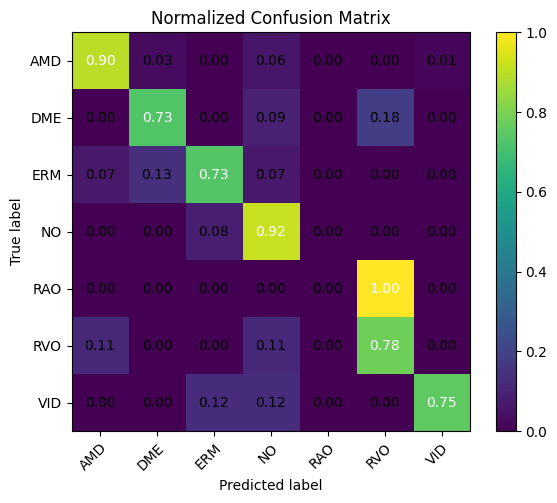

In [31]:
# Step 11: patient-level aggregation (majority vote across slices) and metrics

# 1) Align test_df rows with the dataloader order (Dataset reset_index ensures alignment)
test_df_reset = test_df.reset_index(drop=True).copy() # create aligned copy
test_df_reset["true_idx"] = test_df_reset["disease"].map(class_to_idx).astype(int) # map true labels to ints
test_df_reset["pred_idx"] = y_pred # attach per-image predictions from Step 9

# 2) Majority vote per patient_id
def majority_vote(series):
    return series.value_counts().idxmax() # return most frequent label

patient_eval = (
    test_df_reset
      .groupby("patient_id")
      .agg(true_idx=("true_idx", majority_vote), # true label per patient (should be constant)
           pred_idx=("pred_idx", majority_vote), # predicted label via majority vote
           n_images=("pred_idx", "size")) # number of slices per patient
      .reset_index()
)

print(f"Patients in TEST set: {len(patient_eval)}") # count unique patients
pat_acc = accuracy_score(patient_eval["true_idx"], patient_eval["pred_idx"]) # patient-level accuracy
print(f"Patient-level accuracy: {pat_acc:.3f}\n")

# 3) Detailed report + confusion matrix at patient level
print(classification_report(patient_eval["true_idx"],
                            patient_eval["pred_idx"],
                            target_names=classes,
                            digits=3)) # precision/recall/F1 per class at patient level

cm_pat = confusion_matrix(patient_eval["true_idx"], patient_eval["pred_idx"],
                          labels=list(range(len(classes)))) # patient-level confusion matrix
plot_cm(cm_pat, classes, normalize=True) # normalized matrix for interpretability


Export metrics + plots to a results folder

In [34]:
# Step 12: export metrics + plots to a results folder

resdir = "results_octdl"
os.makedirs(resdir, exist_ok=True)

# 1) Save IMAGE-LEVEL metrics 
report_img = classification_report(y_true, y_pred, target_names=classes, digits=3, zero_division=0)
with open(os.path.join(resdir, "image_level_report.txt"), "w", encoding="utf-8") as f:
    f.write(f"Generated: {datetime.now()}\n\n")
    f.write(report_img)
    f.write(f"\nTest accuracy: {accuracy_score(y_true, y_pred):.3f}")
    from sklearn.metrics import f1_score
    f.write(f"\nMacro-F1: {f1_score(y_true, y_pred, average='macro'):.3f}\n")

# 2) Save PATIENT-LEVEL metrics 
# recompute/align patient-level eval safely
def majority_vote(series):
    return series.value_counts().idxmax()

test_df_reset = test_df.reset_index(drop=True).copy()
test_df_reset["true_idx"] = test_df_reset["disease"].map(class_to_idx).astype(int)
test_df_reset["pred_idx"] = y_pred

patient_eval = (
    test_df_reset.groupby("patient_id")
    .agg(true_idx=("true_idx", majority_vote),
         pred_idx=("pred_idx", majority_vote),
         n_images=("pred_idx", "size"))
    .reset_index()
)

acc_pat = accuracy_score(patient_eval["true_idx"], patient_eval["pred_idx"])
report_pat = classification_report(patient_eval["true_idx"], patient_eval["pred_idx"],
                                   target_names=classes, digits=3, zero_division=0)
with open(os.path.join(resdir, "patient_level_report.txt"), "w", encoding="utf-8") as f:
    f.write(f"Generated: {datetime.now()}\n\n")
    f.write(report_pat)
    f.write(f"\nPatient-level accuracy: {acc_pat:.3f}\n")

# 3) Save confusion matrices 
import matplotlib.pyplot as plt

def save_cm(cm, classes, out_path, normalize=False):
    cm_show = cm.astype(float)
    if normalize:
        cm_show = cm_show / cm_show.sum(axis=1, keepdims=True).clip(min=1)

    fig, ax = plt.subplots(figsize=(5.5,4.8))
    im = ax.imshow(cm_show, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(classes)),
           yticks=np.arange(len(classes)),
           xticklabels=classes, yticklabels=classes,
           ylabel="True label", xlabel="Predicted label",
           title=("Normalized" if normalize else "Raw") + " Confusion Matrix")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # annotate
    for i in range(cm_show.shape[0]):
        for j in range(cm_show.shape[1]):
            txt = f"{cm_show[i,j]:.2f}" if normalize else f"{int(cm_show[i,j])}"
            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm_show[i,j] > cm_show.max()/2.0 else "black")
    plt.tight_layout()
    plt.savefig(out_path, dpi=220, bbox_inches="tight")
    plt.close(fig)

# image-level CMs
cm_img = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
save_cm(cm_img, classes, os.path.join(resdir, "cm_image_raw.png"), normalize=False)
save_cm(cm_img, classes, os.path.join(resdir, "cm_image_normalized.png"), normalize=True)

# patient-level CM
cm_pat = confusion_matrix(patient_eval["true_idx"], patient_eval["pred_idx"],
                          labels=list(range(len(classes))))
save_cm(cm_pat, classes, os.path.join(resdir, "cm_patient_normalized.png"), normalize=True)

# 4) Save Grad-CAM overlays (one per class if available) 
# reuse gradcam_upsampled() and eval_tf from Step 10b

eval_tf = T.Compose([T.Resize((224,224)), T.ToTensor()])

for cls in classes:
    # get any one test image for this class
    row = test_df[test_df["disease"] == cls].head(1)
    if row.empty:
        continue
    path = row.iloc[0]["path"] if "path" in row.columns else os.path.join(ROOT, cls, f"{row.iloc[0]['file_name']}.jpg")
    img = Image.open(path).convert("L")
    x = eval_tf(img).unsqueeze(0).repeat(1,3,1,1).to(device)

    cam_map, probs, pred_idx = gradcam_upsampled(model, x)
    base = x[0,0].cpu().numpy()

    fig = plt.figure(figsize=(4.2,3.8))
    plt.imshow(base, cmap="gray")
    plt.imshow(cam_map, cmap="jet", alpha=0.35, vmin=0, vmax=1)
    plt.title(f"{cls} | Pred: {classes[pred_idx]}")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(resdir, f"cam_{cls}.png"), dpi=220, bbox_inches="tight")
    plt.close(fig)

print("Results saved to:", os.path.abspath(resdir))


Results saved to: C:\Users\annaj\Desktop\Python\Project OCTDL\results_octdl
